# Cubed sphere grid explanation with Weimer potential

Create a figure explaining the cubed sphere grid object (Figure 1 in paper).

We will use the Weimer (2005) model to get a potential $\Phi$ for the northern hemisphere. Using the differentiation matrices $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$ from the cubed sphere grid object, we can differentiate this scalar field and get the electric field through the relation $\mathbf{E} = -\nabla\Phi$. When ignoring inductive effects this equation relates the electric fieldand the electrostatic potential. We can also get the divergence of the electric field $\mathbf{E}$ by using the $\mathbb D_{\nabla\cdot}$ matrix from the cubed sphere grid object. When applied to a vector field, $\mathbb D_{\nabla\cdot}$ produces the divergence of the vector field. 

Below we:
 1. Set up the cubed sphere projection and grid
 2. Read a Weimer model output file and define electrostatic potential on grid
 3. Get east, north electric field from the potential
 4. Get the divergence of the electric field and multiply by $\epsilon_0$ to get charge density
 5. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import lompe

Re = 6371.2e3    # Earth radius
B0 = 3.12e-5     # Mean magnetic field
eps0 = 8.854e-12 # Electric permittivity of free space 
stencil_size = 1 # Size of the stencil used for numerical differentiation

In [2]:
# temporary to see how run time changes for different parameters
from datetime import datetime
starttime = datetime.now() 

The cube face is centered at the north pole (0$^{\circ}$ longtude and 90$^{\circ}$ latitude) and oriented along the meridian (orientation set to zero implies axis in the east-west direction). the projection is used to set up an equal area grid in cubed sphere coordinates. Here, the grid covers a 20 000 km $\times$ 20 000 km area.

In [3]:
Lres, Wres = 10e3, 10e3
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0) # east, west oriented xi-axis
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, Lres, Wres, R = Re+110e3)
SKIP = 20 # how many grid points to skip when smoothing 

Next, we read a Weimer (2005) model output file and interpolate the potential $\Phi$ on the grid:

In [4]:
# read potential file:
weimer = pd.read_table('./weimer.txt', sep = ' ', skipinitialspace = True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt .values.reshape((181, 61)) * 15  # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'linear', rescale = True).reshape(grid.shape)

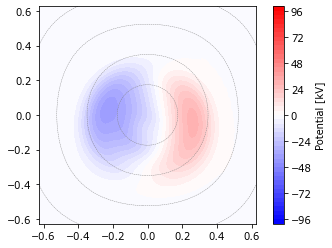

In [5]:
# temporary
fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.contourf(grid.xi, grid.eta, V*1e-3, cmap = plt.cm.bwr, levels = np.r_[-100:101:4])
ax.set_aspect('equal')
ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
plt.colorbar(c, label='Potential [kV]')

We smooth the scalar field before further calculations:

In [6]:
V = median_filter(V, size = 4*SKIP, mode = 'constant', cval = 0)

The grid object contains the matrices that produces derivative in eastward and northward direction of a scalar field defined on the grid: $\mathbb D_{\mathbf{e}\cdot\nabla}$, $\mathbb D_{\mathbf{n}\cdot\nabla}$. We use the matrices to differentiate $\Phi$ to get electric field components:
\begin{equation*}
    \mathbf{E}_{\mathbf{e}} = -\mathbb D_{\mathbf{e}\cdot\nabla}\cdot\Phi
\end{equation*}
\begin{equation*}
    \mathbf{E}_{\mathbf{n}} = -\mathbb D_{\mathbf{n}\cdot\nabla}\cdot\Phi
\end{equation*}
    
The stencil_size scales the interval for the final difference calculation of the derivatives. A larger stencil size will usually yield more accurate derivatives, but is more sensitive to noise. We have stencil_size = 1, and the derivatives are calculated with a 3-point stencil.
    
    TODO: WHY RETURN SPARSE?
We choose to make the differation matrices sparse (if not they would be vary large?).

In [7]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_e = -De.dot(V.flatten()).reshape(grid.shape)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)

$\mathbf{E}$ is a $2N$ element column vector $\mathbf{E}=\begin{pmatrix}\mathbf{E}_{\mathbf{e}}\\\mathbf{E}_{\mathbf{n}}\end{pmatrix}$, where $N$ is the number of grid cells.

We can also calculate the divergence of the electric field:
\begin{equation*}
    \nabla\cdot\mathbf{E} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathbf{E}_{\mathbf{e}}\\\mathbf{E}_{\mathbf{n}}\end{pmatrix}
\end{equation*}

The grid object contains the matrix that produces the divergence of a vector field (here: $\mathbf{E}$) on the grid: $\mathbb D_{\nabla\cdot}$. $\mathbb D_{\nabla\cdot}$ is a $2N\times N$ matrix that operates on $\mathbf{E}$ that has length $2N$.

The divergence of the electric field is related to the charge density, $\rho_c$, through Gauss' law:
\begin{equation*}
    \rho_c = \epsilon_0\nabla\cdot\mathbf{E}
\end{equation*}
where $\epsilon_0$ is the permittivity of free space (constant).

In [8]:
E_tot = np.hstack((E_e.flatten(), E_n.flatten()))

# use cubedsphere divergence matrix to get div(E)
Ddiv = grid.divergence(S = stencil_size, return_sparse = True)
divE = Ddiv.dot(E_tot).reshape(grid.shape)

# convert to charge density - Gauss' law
epsdivE = divE * eps0 

    TODO: Remove smooth electric field and div(E) for plotting:

In [9]:
#E_e = median_filter(E_e, size = 3*SKIP, mode = 'constant', cval = 0)
#E_n = median_filter(E_n, size = 3*SKIP, mode = 'constant', cval = 0)
#divE = median_filter(divE, size = 3*SKIP, mode = 'constant', cval = 0)


To avoid plotting results of edge effects, we remove the lower latitudes before plotting:

In [10]:
E_e[grid.lat < 61] = np.nan
E_n[grid.lat < 61] = np.nan
epsdivE[grid.lat < 61] = np.nan

    TODO: check that scales for E-field and epsdivE are correct

In [11]:
divE2 = median_filter(divE, size = 3*SKIP, mode = 'constant', cval = 0)
epsdivE2 = divE2 * eps0 

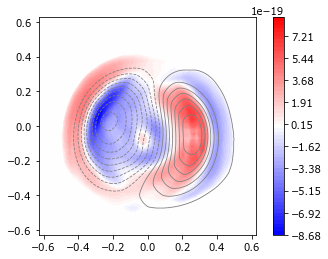

In [12]:
fig = plt.figure()
ax= fig.add_subplot(111)
# color scale for charge density (eps*divE)
divscalelimits2 = np.nanmax((np.abs(epsdivE2))) * 1e18 # added temporarily 
divElevels2 = np.linspace(-divscalelimits2, divscalelimits2, 60) * 1e-18
#divElevels = np.linspace(-0.5, 0.5, 50) * 1e-18

# divE = D_div * E
# epsdivE = eps*divE
ax.contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
c = ax.contourf(grid.xi, grid.eta, epsdivE2, cmap = plt.cm.bwr, levels = divElevels2)
ax.set_aspect('equal')
plt.colorbar(c)

Set up figure and plot:

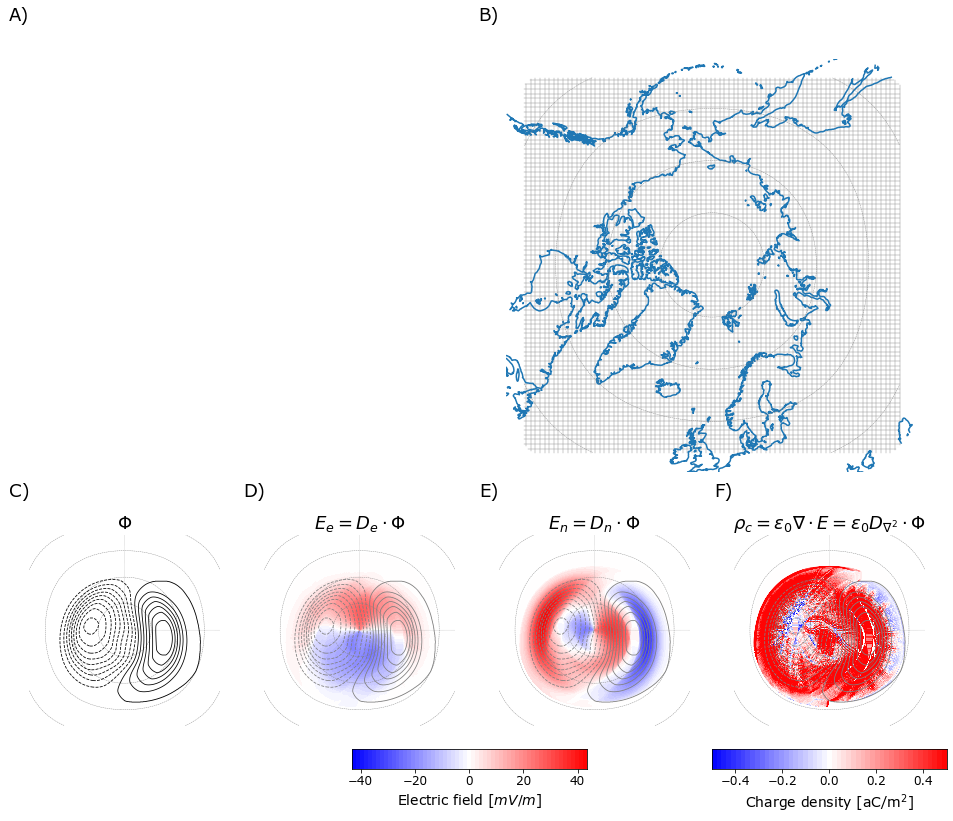

In [15]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (12*1.25, 9*1.25))

axs1, axs2 = {}, {} # initialize dictionaries for axes

# upper row
axs1['onsphere' ] = plt.subplot2grid((25, 40), (2,  0), rowspan = 13, colspan = 20)
axs1['grid'     ] = plt.subplot2grid((25, 40), (2, 20), rowspan = 13, colspan = 20)
axs1['label'    ] = plt.subplot2grid((25, 40), (1,  0))
axs1['label2'   ] = plt.subplot2grid((25, 40), (1, 20))

# lower row
axs2['potential'] = plt.subplot2grid((25, 40), (17,  0), rowspan = 6, colspan = 10)
axs2['E_e'      ] = plt.subplot2grid((25, 40), (17, 10), rowspan = 6, colspan = 10)
axs2['E_n'      ] = plt.subplot2grid((25, 40), (17, 20), rowspan = 6, colspan = 10)
axs2['Ediv'     ] = plt.subplot2grid((25, 40), (17, 30), rowspan = 6, colspan = 10)

axs2['label'    ] = plt.subplot2grid((25, 40), (16, 0))
axs2['label2'   ] = plt.subplot2grid((25, 40), (16, 10))
axs2['label3'   ] = plt.subplot2grid((25, 40), (16, 20))
axs2['label4'   ] = plt.subplot2grid((25, 40), (16, 30))

axs2['cbar'     ] = plt.subplot2grid((40, 60), (38, 22), colspan = 15) # for electric fields
axs2['cbar2'    ] = plt.subplot2grid((40, 60), (38, 45), colspan = 15) # for div(E)

plt.subplots_adjust(hspace = 0, wspace = 0, left = 0.05, right = .92, bottom = 0.01 ,top = .99)

# labels
axs1['label' ].set_title('A)', fontsize = 18)
axs1['label2'].set_title('B)', fontsize = 18)
axs2['label' ].set_title('C)', fontsize = 18)
axs2['label2'].set_title('D)', fontsize = 18)
axs2['label3'].set_title('E)', fontsize = 18)
axs2['label4'].set_title('F)', fontsize = 18)

###################### upper row of plots #########################

# set up axes for grid visualization
for key in axs1.keys():
    axs1[key].set_axis_off()
    if 'label' in key:
        continue
    axs1[key].set_aspect('equal')

# A) example of cube face intersecting sphere 
    
# B) cubed sphere grid with coastlines
count = 0
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    count += 1
    if count%10 !=0:
        continue
    axs1['grid'].plot(xi, eta, color = 'grey', linewidth = .4)

# add coastlines
xlim, ylim = axs1['grid'].get_xlim(), axs1['grid'].get_ylim()
for cl in grid.projection.get_projected_coastlines():
    axs1['grid'].plot(cl[0], cl[1], color = 'C0')

# add latitude contours
axs1['grid'].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
                                              linewidths = .4, levels = np.r_[-80:81:10])
    
axs1['grid'].set_xlim(xlim)
axs1['grid'].set_ylim(ylim)

###################### lower row of plots #########################

# Set up axis for phi, Ee, En, divE
for key in axs2.keys():
    if 'cbar' in key: 
        continue
    axs2[key].set_axis_off()
    if 'label' in key:
        continue
    axs2[key].set_aspect('equal')
    axs2[key].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
    axs2[key].contour(grid.xi, grid.eta, grid.lon/15, levels = [6, 12, 18], linestyles = ':', colors = 'gray', linewidths = .4)
    
# C) Potential
# f = Phi
axs2['potential'].set_title(r'$\Phi$', fontsize = 18)
axs2['potential'].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)

# color scale for east, north E-field
Escalelimits = np.nanmax((np.abs(E_n), np.abs(E_e))) * 1e3 # added temporarily 
Elevels = np.linspace(-Escalelimits, Escalelimits, 60) * 1e-3

# D) eastward electric field
# E_e = D_e * Phi
axs2['E_e'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_e'].contourf(grid.xi, grid.eta, E_e, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_e'].set_title(r'$E_e = D_e \cdot \Phi$', fontsize = 18)

# E) northward electric field
# E_n = D_n * Phi
axs2['E_n'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_n'].contourf(grid.xi, grid.eta, E_n, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_n'].set_title(r'$E_n = D_n \cdot \Phi$', fontsize = 18)

# color bar for east, north electric fields
x = np.vstack((Elevels, Elevels)).T
y = np.vstack((np.zeros(Elevels.size), np.ones(Elevels.size))).T
axs2['cbar'].contourf(x*1e3, y, x*1e3, levels = Elevels*1e3, cmap = plt.cm.bwr)
axs2['cbar'].set_yticks([])
axs2['cbar'].xaxis.set_label_position("bottom")
axs2['cbar'].xaxis.tick_bottom()
axs2['cbar'].tick_params(axis = 'x', labelsize = 12)
axs2['cbar'].set_xlabel('Electric field [$mV/m$]', fontsize = 14)


# F) charge density

# color scale for charge density (eps*divE)
divscalelimits = np.nanmax((np.abs(epsdivE))) * 1e18 # added temporarily 
#divElevels = np.linspace(-divscalelimits, divscalelimits, 60) * 1e-18
divElevels = np.linspace(-0.5, 0.5, 50) * 1e-18

# divE = D_div * E
# epsdivE = eps*divE
axs2['Ediv'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['Ediv'].contourf(grid.xi, grid.eta, epsdivE, cmap = plt.cm.bwr, levels = divElevels)
axs2['Ediv'].set_title(r'$\rho_c=\epsilon_0 \nabla \cdot E = \epsilon_0 D_{\nabla^2} \cdot \Phi$', fontsize = 18);

# color bar for div(E)
x = np.vstack((divElevels, divElevels)).T
y = np.vstack((np.zeros(divElevels.size), np.ones(divElevels.size))).T
axs2['cbar2'].contourf(x*1e18, y, x*1e18, levels = divElevels*1e18, cmap = plt.cm.bwr)
axs2['cbar2'].set_yticks([])
axs2['cbar2'].xaxis.set_label_position("bottom")
axs2['cbar2'].xaxis.tick_bottom()
axs2['cbar2'].tick_params(axis = 'x', labelsize = 12)
axs2['cbar2'].set_xlabel(r'Charge density [aC/m$^2$]', fontsize = 14); # really aC/m^3

In [14]:
# temporary to see how run time changes for different parameters

endtime = datetime.now()
runtime = endtime - starttime
sec = runtime.seconds
print(f'Total run time:   {sec} seconds')

Total run time:   38 seconds
